In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import forward_backward as fb
np.random.seed(12345)

In [2]:
def generating_states(pi,A,Ntimes):
    
    Q = np.empty(Ntimes).astype('int')

    Nstates=np.shape(A)[0]
    
    states = np.zeros((Nstates, Ntimes))
    
    Q[0]=np.random.choice(Nstates,1,p=pi)[0]
    
    states[int(Q[0]),0]=1
    
    for t in range(1, Ntimes):
        
        Q[t]=np.random.choice(Nstates,1,p=A[Q[t-1]])[0]
        
        states[Q[t],t]=1
        
    return Q, states

In [3]:
pi=np.array([.8,.2])
A = np.array([[.6, .4, ], [.5, .5]])
Ntimes=50
Nstates=2

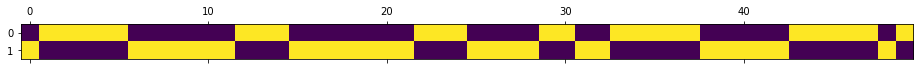

In [4]:
Q, states=generating_states(pi,A,Ntimes)

plt.matshow(states)

In [5]:
def generating_observations(Q,B):

    Ntimes=np.size(Q)
    
    O = np.empty(Ntimes).astype('int')
    
    Nstates=np.size(B[:,0])
    
    Nobservations= np.size(B[0,:])
    
    O_mat=np.zeros((Nobservations,Ntimes))
    
    for t in range(Ntimes):
        
        O[t]=np.random.choice(Nobservations,1,p=B[Q[t-1]])[0]
        
        O_mat[O[t],t]=1
        
    return O, O_mat

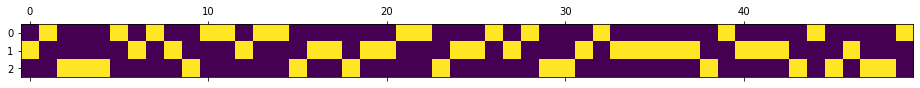

In [6]:
B = np.array([[.2, .4, .4], [.5, .4, .1]])

O, O_mat = generating_observations(Q,B)    
plt.matshow(O_mat)    

#Generate observations from the state
#do forward to due to the probabliities

# Run forward-backward to recover states (assuming $A$, $\pi$, $B$ known)

First, let's check against John's code:

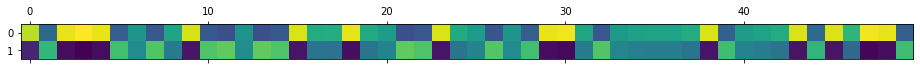

In [7]:
# make an array that's p(obs_t | z_t) for each possible z at each time (Ntimes x Nstates)
psi = np.array([B[:, o] for o in O])

post, logZ, Xi = fb.fb_infer(A.T, pi, psi)

plt.matshow(post.T)

In [8]:
# get intermediate quantitites from John's implementation

def john_setup(psi, A, pi):
    """
    Note: Uses John's conventions for A (i.e., columns sum to 1)
    """

    jv = dict()
    T = psi.shape[0]
    M = A.shape[0]
    jv['T'] = T
    jv['M'] = M

    # initialize empty variables
    jv['alpha'] = np.empty((jv['T'], M))  # p(z_t|y_{1:T})
    jv['beta'] = np.empty((T, M))  # p(y_{t+1:T}|z_t) (unnormalized)
    jv['gamma'] = np.empty((T, M))  # p(z_t|y_{1:T}) (posterior)
    jv['logZ'] = np.empty(T)  # log partition function
    jv['Xi'] = np.empty((T - 1, M, M))

    # initialize
    a = psi[0] * pi
    jv['a'] = a
    jv['alpha'][0] = a / np.sum(a)
    jv['logZ'][0] = np.log(np.sum(a))
    jv['beta'][-1, :] = 1
    jv['beta'][-1, :] = jv['beta'][-1, :] / np.sum(jv['beta'][-1, :])
    
    return jv

jv = john_setup(psi, A, pi)

fb.forward(psi, A.T, jv['alpha'], jv['logZ'], jv['a'])
fb.backward(psi, A.T, jv['beta'], jv['a'])
fb.calc_post(jv['alpha'], jv['beta'], jv['gamma'])

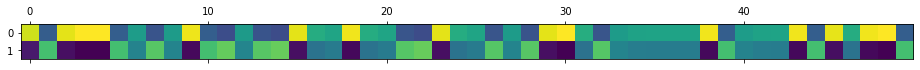

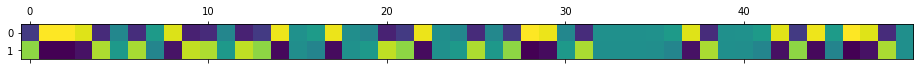

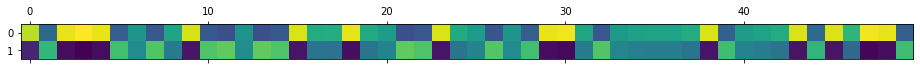

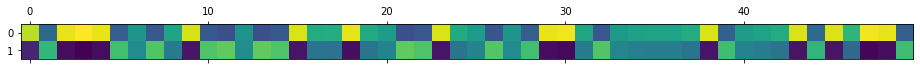

In [9]:
plt.matshow(jv['alpha'].T)
plt.matshow(jv['beta'].T)
plt.matshow(jv['gamma'].T)
plt.matshow(post.T)

In [10]:
def forward(O, A, B, pi):
    
    T = O.shape[0]
    
    N = A.shape[0]
    
    alpha = np.empty((N, T))# p(z_t|y_{1:T})
    alpha2 = np.empty((N, T))# p(z_t|y_{1:T})
    
    alpha[:,0]=pi*B[:,int(O[0])]
        
    alpha[:,0]=alpha[:,0]/sum(alpha[s,0] for s in range(N))
      
    for t in range(1,T):
        
        asum = sum([sum([alpha[j,t-1]*A[j,s]*B[s,int(O[t])]  for j in range(N)]) for s in range(N)])
        
        for s in range(N):
            
            alpha2[s,t]=sum([alpha[j,t-1]*A[j,s]*B[s,int(O[t])] for j in range(N)])
        
        alpha[:,t]=alpha2[:,t]   
        
        for s in range(N):
            
            alpha[s,t] =alpha[s,t]/asum
        
    forwardprob = np.sum(alpha,0)
        
    logZ = np.log(forwardprob)
    
    return forwardprob, alpha, logZ

In [11]:
def backward(O,A,B):
    T = O.shape[0]
    
    N = A.shape[0]
    
    beta = np.empty((N, T))# p(z_t|y_{1:T})
    beta2 = np.empty((N, T))# p(z_t|y_{1:T})
    beta[:,-1] = 1
            
    beta[:,-1] = beta[:,-1]/sum(beta[s,-1] for s in range(N))
       
    for t in range(T - 1, 0, -1):
        
        bsum=sum([sum([beta[j,t]*A[s,j]*B[j,int(O[t])] for j in range(N)]) for s in range(N)])
        
        for s in range(N):
            
            beta2[s,t-1]=sum([beta[j,t]*A[s,j]*B[j,int(O[t])] for j in range(N)])
            
        beta[:,t-1]=beta2[:,t-1] 
        
        for s in range(N):
            
            beta[s,t-1]=beta[s,t-1]/bsum
            
    backwardprob = np.sum(beta,0)
    
    return backwardprob, beta

In [12]:
def gamma_solver(alpha, beta):
    
    N, T= alpha.shape
    
    gamma = np.empty((N,T))
    
    for t in range(T):
        gamsum=0.0
        for s in range(N):
            
            gamma[s,t] = (alpha[s,t] * beta[s,t])
            
            gamsum +=gamma[s,t]
        
        for s in range(N):
            
            gamma[s,t] =gamma[s,t]/gamsum
     
    return gamma

In [13]:
forwardprob, alpha, logZ = forward(O, A, B, pi)

Text(0.5, 1.05, "John's alpha")

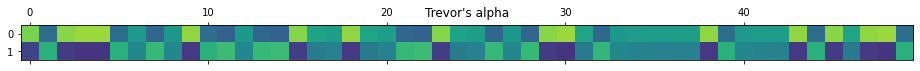

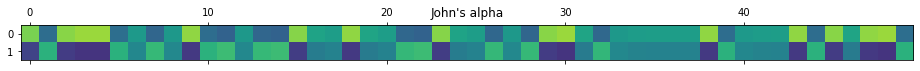

In [14]:
plt.matshow(alpha, vmin=0, vmax=1)
plt.title("Trevor's alpha")

plt.matshow(jv['alpha'].T, vmin=0, vmax=1)
plt.title("John's alpha")

In [15]:
backwardprob, beta = backward(O, A, B)

Text(0.5, 1.05, "John's beta")

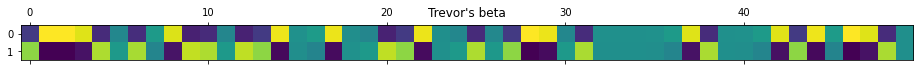

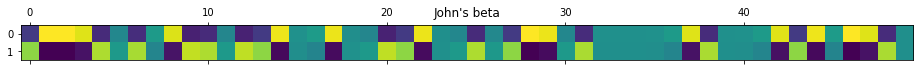

In [16]:
plt.matshow(beta)
plt.title("Trevor's beta")

plt.matshow(jv['beta'].T)
plt.title("John's beta")

In [17]:
gamma = gamma_solver(alpha, beta)

Text(0.5, 1.05, "John's gamma")

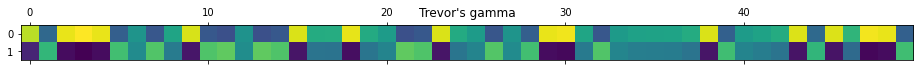

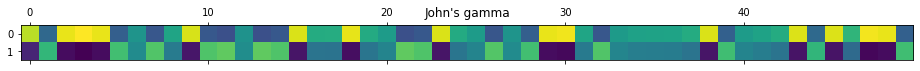

In [18]:
plt.matshow(gamma)
plt.title("Trevor's gamma")

plt.matshow(jv['gamma'].T)
plt.title("John's gamma")

In [47]:
def delta_solver(alpha,beta,A,B):

    N, T = alpha.shape
    
    delta = np.empty((N,N,T))
    
    for t in range(T-1):
        
        for s in range(N):
            
            for j in range(N):
                
                delta[s,j,t]= alpha[s,t]*A_guess[s,j]*B_guess[j,int(O[t+1])-1]*beta[j,t+1]/alpha[-1,-1]
                
    deltaprob = np.sum(delta,0)
    
    delta=delta/deltaprob
    
    return delta

In [48]:
def EM(A_guess,B_guess,O,iterate,pi):

    for step in range(iterate):  

        N, Nobservations = B_guess.shape

        T = O.shape[0]

        forwardprob, alpha, logZ = forward(O,A_guess,B_guess, pi)

        backwardprob, beta = backward(O,A_guess,B_guess)
        

        gamma=gamma_solver(alpha,beta)

        delta=delta_solver(alpha,beta,A_guess,B_guess)
        
        for v in range(Nobservations):
            
            for j in range(N):
                
                B_guess[j,v]=sum([gamma[j,t] for t in range(T) if v==O[t]])/sum([gamma[j,t] for t in range(T)])
                
        for s in range(N):
            
            for j in range(N):
                
                 A_guess[s,j]= sum(delta[s,j,t] for t in range(T-1))/sum(np.sum(delta[s,:,t],0) for t in range(T-1))
    
    A=A_guess
    B=B_guess
    return A, B, alpha, beta, gamma, forwardprob

In [43]:
A = np.array([[.6, .4, ], [.5, .5]])
B = np.array([[.2, .4, .4], [.5, .4, .1]])
pi=[.8,.2]


A_New, B_New, alpha4, beta4, gamma, forwardprob =EM(A,B,O,1,pi)

plt.matshow(states)
plt.title('states')
plt.matshow(alpha4, vmin=0,vmax=1)
plt.title('Trevor''s alpha')
plt.matshow(beta4, vmin=0, vmax=1)
plt.title('Trevor''s beta')
plt.matshow(gamma, vmin=0, vmax=1)
plt.title('Trevor''s gamma')

NameError: name 'A_guess' is not defined

Text(0.5, 1.05, 'Trevors gamma')

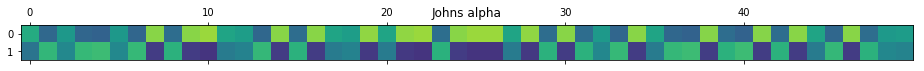

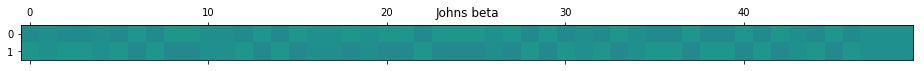

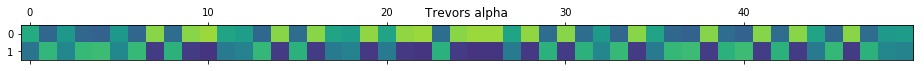

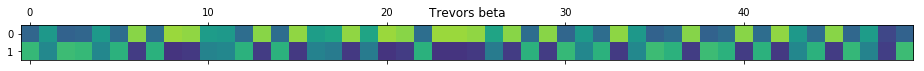

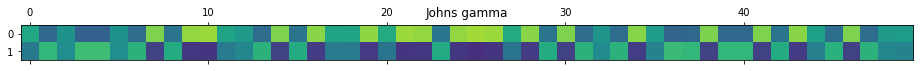

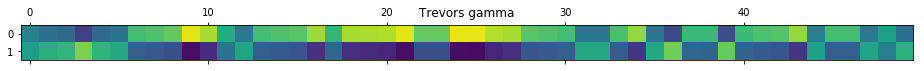

In [35]:
A = np.array([[.6, .4, ], [.5, .5]])
B = np.array([[.2, .4, .4], [.5, .4, .1]])
pi=[.8,.2]
J_gamma, uh2, uh3= fb_infer(np.array(A).T,np.array(pi),np.array(B[:,O.astype(int)]).T)
plt.matshow(alpha4,vmin=0, vmax=1)
plt.title('Trevor''s alpha')
plt.matshow(beta4, vmin=0, vmax=1)
plt.title('Trevor''s beta')
plt.matshow(J_gamma.T, vmin=0, vmax=1)
plt.title('John''s gamma')
plt.matshow(gamma, vmin=0, vmax=1)
plt.title('Trevor''s gamma')



When I added v_min=0 and v_max=1 to your beta on the plot the distinction became more clear as to why alpha seems to dominate the gamma in your fb_infer. But I couldn't figure out why or how yours was different